In [ ]:
!pip install mpi4py matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.2/466.2 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-4.0.1-cp310-cp310-linux_x86_64.whl size=4266346 sha256=fce298a585d2a326dc2aba405ae699c075b58b960482aa78e5b9b06c8b87e2de
  Stored in directory: /root/.cache/pip/wheels/3c/ca/13/13218a83854023ccec184e3af482f0f038b434aa32c19afee8
Successfully built mpi4py


Regression line equation: y = 6.23x + 50.15
Interpretation: For each hour studied, the grade increases by approximately 6.23 points.


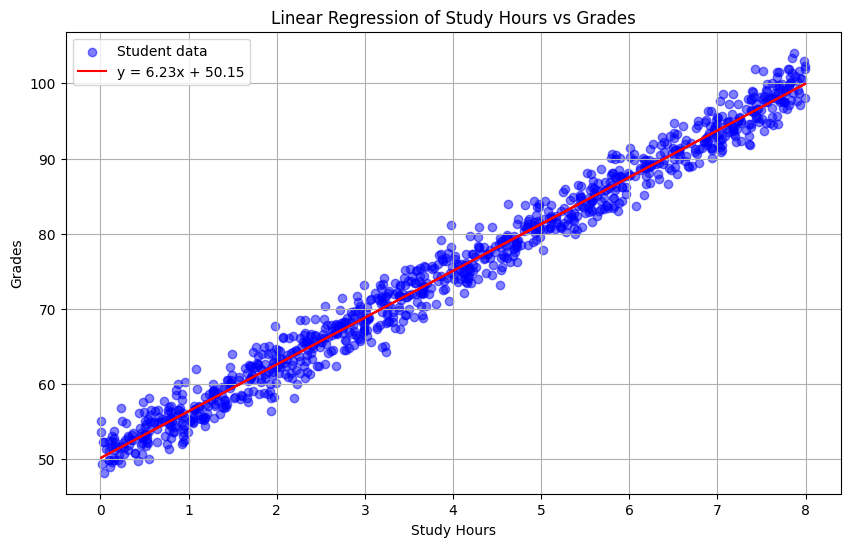

In [ ]:
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

# MPI setup
comm = MPI.COMM_WORLD  # Initialize the communicator
rank = comm.Get_rank()  # Get the rank (ID) of each process
size = comm.Get_size()  # Total number of processes

# Data configuration
num_students = 1000  # Number of students
if rank == 0:
    # Generate synthetic data on process 0 (master)
    np.random.seed(0)
    hours_studied = np.random.rand(num_students) * 8  # Study hours between 0 and 8
    # Generate grades between 50 and 100 with a linear relationship to study hours
    grades = 50 + (hours_studied * 6.25) + np.random.randn(num_students) * 2  # Grades between 50 and 100
else:
    hours_studied = None
    grades = None

# Scatter the data among processes
num_data_per_process = num_students // size
hours_chunk = np.empty(num_data_per_process, dtype='d')
grades_chunk = np.empty(num_data_per_process, dtype='d')

# Split the data among processes
comm.Scatter(hours_studied, hours_chunk, root=0)
comm.Scatter(grades, grades_chunk, root=0)

# Calculate partial sums on each process
local_sum_x = np.sum(hours_chunk)
local_sum_y = np.sum(grades_chunk)
local_sum_x2 = np.sum(hours_chunk**2)
local_sum_xy = np.sum(hours_chunk * grades_chunk)

# Gathering partial results and summing them on the root process
total_sum_x = comm.reduce(local_sum_x, op=MPI.SUM, root=0)
total_sum_y = comm.reduce(local_sum_y, op=MPI.SUM, root=0)
total_sum_x2 = comm.reduce(local_sum_x2, op=MPI.SUM, root=0)
total_sum_xy = comm.reduce(local_sum_xy, op=MPI.SUM, root=0)

# Synchronize processes
comm.Barrier()

# Process 0 calculates the regression line equation and generates the plot
if rank == 0:
    # Linear regression equation y = mx + c
    m = (num_students * total_sum_xy - total_sum_x * total_sum_y) / (num_students * total_sum_x2 - total_sum_x**2)
    c = (total_sum_y - m * total_sum_x) / num_students
    print(f"Regression line equation: y = {m:.2f}x + {c:.2f}")
    print(f"Interpretation: For each hour studied, the grade increases by approximately {m:.2f} points.")

    # Plot the data and the regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(hours_studied, grades, color="blue", label="Student data", alpha=0.5)
    plt.plot(hours_studied, m * hours_studied + c, color="red", label=f"y = {m:.2f}x + {c:.2f}")
    plt.xlabel("Study Hours")
    plt.ylabel("Grades")
    plt.title("Linear Regression of Study Hours vs Grades")
    plt.legend()
    plt.grid(True)
    plt.show()

# Final barrier to ensure all processes finish at the same time
comm.Barrier()